In [1]:
import math
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_theme(style="ticks", palette="pastel")

import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

## Loading of dataset

In [2]:
path_default = "./data/stock_data.csv"
stock_data = pd.read_csv(path_default)
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data.head(5)

,Date,Open,High,Low,Close,Volume,OpenInt,Stock
0,1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0,AAPL
1,1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0,AAPL
2,1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0,AAPL
3,1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0,AAPL
4,1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0,AAPL


In [3]:
companies = stock_data['Stock'].unique()
print(companies)

['AAPL' 'TSLA' 'MSFT' 'FB']


## Split training and test set

In [4]:
stocks ={}
for i in companies:
  stocks[i]= pd.DataFrame()
  stocks[i] = stocks[i].append((stock_data[stock_data['Stock'] == i][["Date", "Close"]]), ignore_index=True)
  print(stocks[i].head(5),stocks[i].shape)

        Date    Close
0 1984-09-07  0.42388
1 1984-09-10  0.42134
2 1984-09-11  0.42902
3 1984-09-12  0.41618
4 1984-09-13  0.43927 (8364, 2)
        Date  Close
0 2010-06-28  17.00
1 2010-06-29  23.89
2 2010-06-30  23.83
3 2010-07-01  21.96
4 2010-07-02  19.20 (1858, 2)
        Date    Close
0 1986-03-13  0.07533
1 1986-03-14  0.07533
2 1986-03-17  0.07533
3 1986-03-18  0.07533
4 1986-03-19  0.07533 (7983, 2)
        Date  Close
0 2012-05-18  38.23
1 2012-05-21  34.03
2 2012-05-22  31.00
3 2012-05-23  32.00
4 2012-05-24  33.03 (1381, 2)


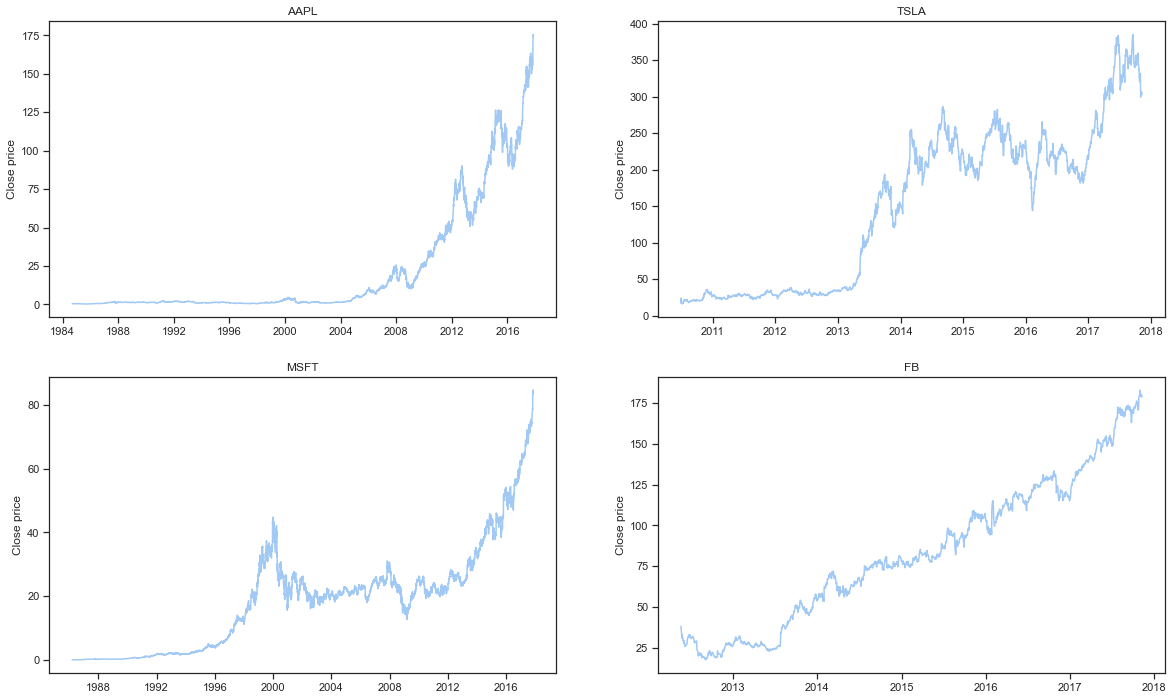

In [5]:
plt.figure(figsize=(20, 12))
for index, key in enumerate(companies):
  plt.subplot(2, 2, index + 1)
  plt.plot(stocks[key]["Date"], stocks[key]["Close"])
  plt.title(key)
  plt.ylabel('Close price')

In [6]:
# Normalizing the Data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [7]:
def SplitData(data, time_slice):
    index_mark = int(len(data) * 0.8)
    close_train=data['Close'][0:index_mark].values
    
    X_train = []
    Y_train = []
    for i in range(index_mark - time_slice):
        X_train.append(close_train[i:i+time_slice])
        Y_train.append(close_train[i+time_slice])
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_train = X_train.reshape((-1, 5, 1)) 
    Y_train = Y_train.reshape(-1, 1)

    close_test=data['Close'][index_mark:].values
    X_test = []
    Y_test = []
    for i in range(len(close_test) - time_slice):
        X_test.append(close_test[i:i+time_slice])
        Y_test.append(close_test[i+time_slice])
    X_test, Y_test = np.array(X_test), np.array(Y_test)
    X_test = X_test.reshape((-1, 5, 1))
    Y_test = Y_test.reshape(-1, 1)

    return X_train, Y_train, X_test, Y_test

## Create model

In [8]:
def Model():
  model = tf.keras.models.Sequential(
      [
          tf.keras.layers.LSTM(200, input_shape = (5, 1), activation = tf.nn.leaky_relu, return_sequences = True),
          tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu),
          tf.keras.layers.Dense(200, activation = tf.nn.leaky_relu),
          tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
          tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
          tf.keras.layers.Dense(1, activation = tf.nn.leaky_relu)
      ]
  )
  return model

In [9]:
model = Model()

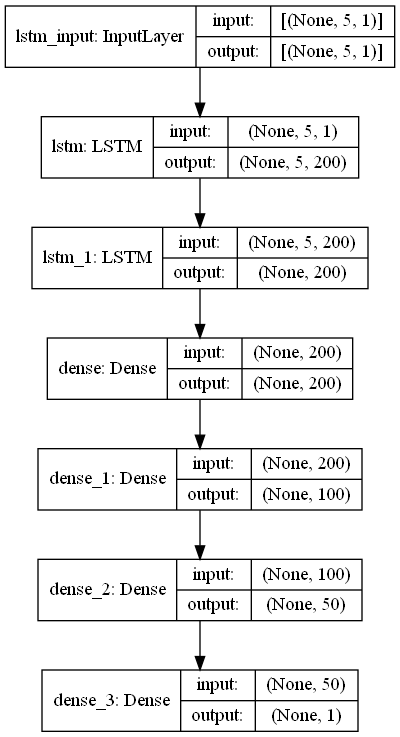

In [10]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 200)            161600    
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense (Dense)                (None, 200)               40200     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 547,801
Trainable params: 547,801
Non-trainable params: 0
__________________________________________________

## Custom Learning Rate

In [12]:
def scheduler(epoch):
  
  if epoch <= 150:
    lrate = (10 ** -5) * (epoch / 150) 
  elif epoch <= 400:
    initial_lrate = (10 ** -5)
    k = 0.01
    lrate = initial_lrate * math.exp(-k * (epoch - 150))
  else:
    lrate = (10 ** -6)
  
  return lrate

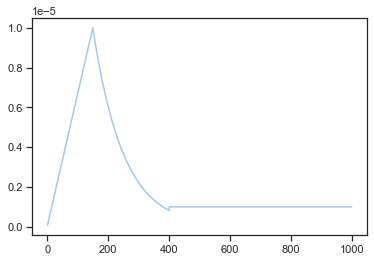

In [13]:
epochs = [i for i in range(1, 1001, 1)]
lrate = [scheduler(i) for i in range(1, 1001, 1)]
plt.plot(epochs, lrate)
plt.show()

In [14]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

## Train model

### Apple model

In [15]:
AAPL_X_train, AAPL_Y_train, AAPL_X_test, AAPL_Y_test = SplitData(stocks['AAPL'], 5)

In [16]:
AAPL_Model = Model()

In [17]:
AAPL_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [18]:
# Measuring the time taken by the model to train
start_time=time.time()
AAPL_hist = AAPL_Model.fit(AAPL_X_train, AAPL_Y_train, epochs = 100, validation_data = (AAPL_X_test, AAPL_Y_test), callbacks=[callback])
end_time=time.time()
print("## Total Time Taken: ", round((end_time-start_time)/60), 'Minutes ##')

Epoch 1/100
209/209 [==============================] - 11s 30ms/step - loss: 102.4827 - root_mean_squared_error: 10.1182 - val_loss: 9260.1279 - val_root_mean_squared_error: 96.2296
Epoch 2/100
209/209 [==============================] - 4s 21ms/step - loss: 103.8735 - root_mean_squared_error: 10.1845 - val_loss: 9258.2656 - val_root_mean_squared_error: 96.2199
Epoch 3/100
209/209 [==============================] - 6s 27ms/step - loss: 101.5649 - root_mean_squared_error: 10.0673 - val_loss: 9254.6406 - val_root_mean_squared_error: 96.2010
Epoch 4/100
209/209 [==============================] - 8s 36ms/step - loss: 103.7846 - root_mean_squared_error: 10.1859 - val_loss: 9249.2002 - val_root_mean_squared_error: 96.1728
Epoch 5/100
209/209 [==============================] - 7s 34ms/step - loss: 99.7622 - root_mean_squared_error: 9.9855 - val_loss: 9239.3994 - val_root_mean_squared_error: 96.1218
Epoch 6/100
209/209 [==============================] - 5s 24ms/step - loss: 102.2306 - root_mean

In [19]:
AAPL_Model.save('./model/AAPL/AAPL_model.h5')

In [20]:
history_dict = AAPL_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

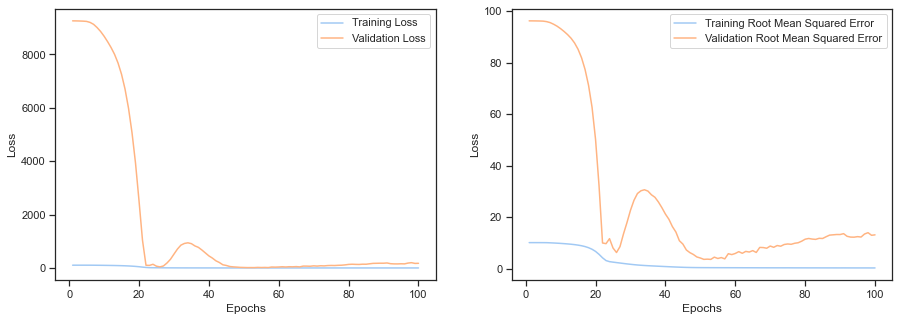

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

In [22]:
### Predicting the closing stock price
AAPL_prediction = AAPL_Model.predict(AAPL_X_test).reshape(-1,1)

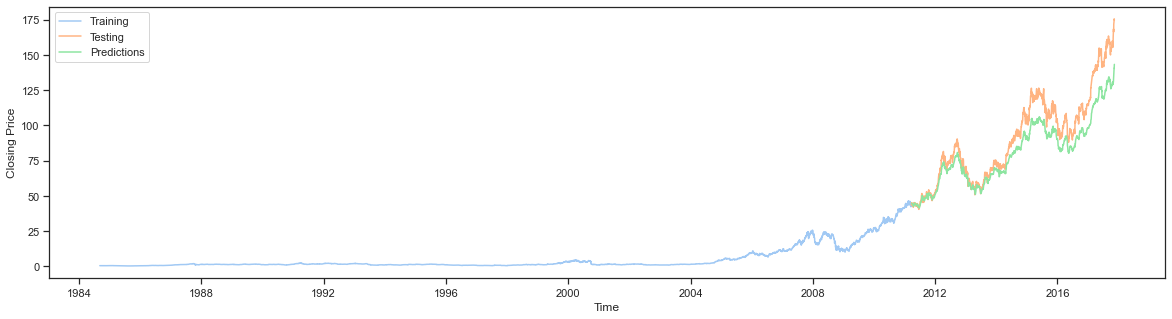

In [23]:
plt.figure(figsize=(20, 5))
i_AAPL_mark = int(len(stocks['AAPL']) * 0.8)
plt.plot(stocks['AAPL']['Date'][:i_AAPL_mark], 
        stocks['AAPL']['Close'][:i_AAPL_mark], label = 'Training')

plt.plot(stocks['AAPL']['Date'][i_AAPL_mark:], 
        stocks['AAPL']['Close'][i_AAPL_mark:], label = 'Testing')

plt.plot(stocks['AAPL']['Date'][i_AAPL_mark+5:], 
        AAPL_prediction.reshape(-1), label = 'Predictions')

plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [24]:
from sklearn.metrics import r2_score
r2 = r2_score(AAPL_Y_test, AAPL_prediction)
rmse = math.sqrt(mean_squared_error(AAPL_Y_test, AAPL_prediction))
mape = np.mean(np.abs(AAPL_prediction - AAPL_Y_test)/np.abs(AAPL_Y_test))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'R2 score: {r2}')

RMSE: 13.19662604693438
MAPE: 0.09614499663106901
R2 score: 0.8217314778763937


### Tesla model

In [25]:
TSLA_X_train, TSLA_Y_train, TSLA_X_test, TSLA_Y_test = SplitData(stocks['TSLA'], 5)

In [26]:
TSLA_Model = Model()

In [27]:
TSLA_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [28]:
# Measuring the time taken by the model to train
start_time=time.time()
TSLA_hist = TSLA_Model.fit(TSLA_X_train, TSLA_Y_train, epochs = 100, validation_data = (TSLA_X_test, TSLA_Y_test), callbacks=[callback])
end_time=time.time()
print("## Total Time Taken: ", round((end_time-start_time)/60), 'Minutes ##')

Epoch 1/100
47/47 [==============================] - 4s 28ms/step - loss: 22643.6910 - root_mean_squared_error: 150.2890 - val_loss: 77455.7188 - val_root_mean_squared_error: 278.3087
Epoch 2/100
47/47 [==============================] - 1s 19ms/step - loss: 23945.4779 - root_mean_squared_error: 154.6989 - val_loss: 77444.5078 - val_root_mean_squared_error: 278.2885
Epoch 3/100
47/47 [==============================] - 1s 20ms/step - loss: 23322.3178 - root_mean_squared_error: 152.7104 - val_loss: 77422.1953 - val_root_mean_squared_error: 278.2484
Epoch 4/100
47/47 [==============================] - 1s 19ms/step - loss: 23126.9193 - root_mean_squared_error: 152.0455 - val_loss: 77387.6328 - val_root_mean_squared_error: 278.1863
Epoch 5/100
47/47 [==============================] - 1s 18ms/step - loss: 22326.5321 - root_mean_squared_error: 149.3342 - val_loss: 77342.3906 - val_root_mean_squared_error: 278.1050
Epoch 6/100
47/47 [==============================] - 1s 18ms/step - loss: 23334.

In [29]:
TSLA_Model.save('./model/TSLA/TSLA_model.h5')

In [30]:
history_dict = TSLA_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

In [31]:
### Predicting the closing stock price
TSLA_prediction = TSLA_Model.predict(TSLA_X_test).reshape(-1,1)

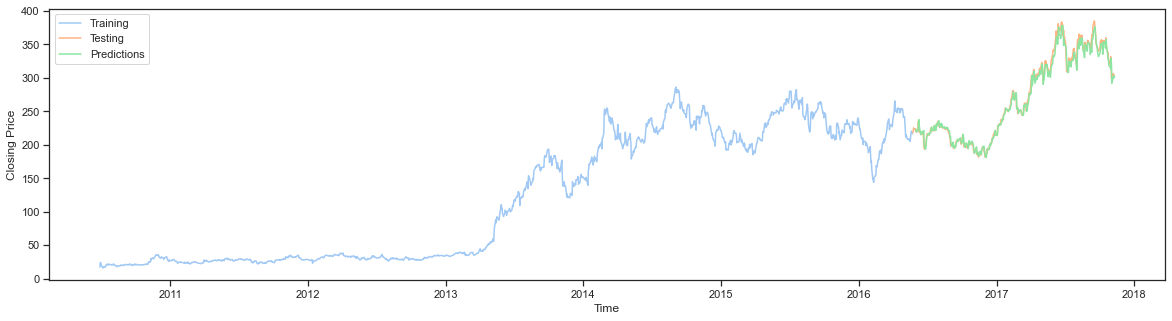

In [32]:
plt.figure(figsize=(20, 5))
i_TSLA_mark = int(len(stocks['TSLA']) * 0.8)
plt.plot(stocks['TSLA']['Date'][:i_TSLA_mark], 
        stocks['TSLA']['Close'][:i_TSLA_mark], label = 'Training')

plt.plot(stocks['TSLA']['Date'][i_TSLA_mark:], 
        stocks['TSLA']['Close'][i_TSLA_mark:], label = 'Testing')

plt.plot(stocks['TSLA']['Date'][i_TSLA_mark+5:], 
        TSLA_prediction.reshape(-1), label = 'Predictions')

plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [33]:
r2 = r2_score(TSLA_Y_test, TSLA_prediction)
rmse = math.sqrt(mean_squared_error(TSLA_Y_test, TSLA_prediction))
mape = np.mean(np.abs(TSLA_prediction - TSLA_Y_test)/np.abs(TSLA_Y_test))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'R2 score: {r2}')

RMSE: 7.32273034286509
MAPE: 0.018878251153946847
R2 score: 0.98623313074141


### Microsoft model

In [34]:
MSFT_X_train, MSFT_Y_train, MSFT_X_test, MSFT_Y_test = SplitData(stocks['MSFT'], 5)

In [35]:
MSFT_Model = Model()

In [36]:
MSFT_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [37]:
# Measuring the time taken by the model to train
start_time=time.time()
MSFT_hist = MSFT_Model.fit(MSFT_X_train, MSFT_Y_train, epochs = 100, validation_data = (MSFT_X_test, MSFT_Y_test), callbacks=[callback])
end_time=time.time()
print("## Total Time Taken: ", round((end_time-start_time)/60), 'Minutes ##')

Epoch 1/100
200/200 [==============================] - 8s 23ms/step - loss: 283.3903 - root_mean_squared_error: 16.8207 - val_loss: 1939.7794 - val_root_mean_squared_error: 44.0429
Epoch 2/100
200/200 [==============================] - 4s 20ms/step - loss: 293.3690 - root_mean_squared_error: 17.1272 - val_loss: 1937.0974 - val_root_mean_squared_error: 44.0125
Epoch 3/100
200/200 [==============================] - 4s 21ms/step - loss: 296.0149 - root_mean_squared_error: 17.2032 - val_loss: 1931.8313 - val_root_mean_squared_error: 43.9526
Epoch 4/100
200/200 [==============================] - 6s 31ms/step - loss: 295.5831 - root_mean_squared_error: 17.1909 - val_loss: 1923.9568 - val_root_mean_squared_error: 43.8629
Epoch 5/100
200/200 [==============================] - 5s 23ms/step - loss: 291.4420 - root_mean_squared_error: 17.0707 - val_loss: 1913.4048 - val_root_mean_squared_error: 43.7425
Epoch 6/100
200/200 [==============================] - 5s 23ms/step - loss: 298.2316 - root_mea

In [38]:
MSFT_Model.save('./model/MSFT/MSFT_model.h5')

In [39]:
history_dict = MSFT_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

In [40]:
### Predicting the closing stock price
MSFT_prediction = MSFT_Model.predict(MSFT_X_test).reshape(-1,1)

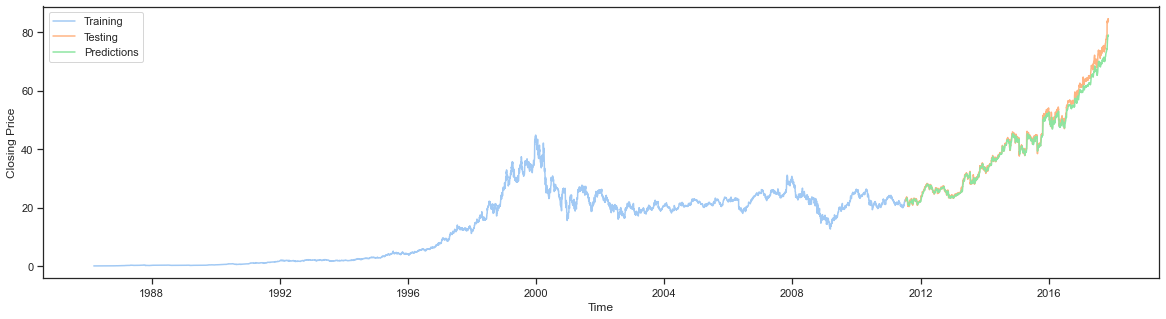

In [41]:
plt.figure(figsize=(20, 5))
i_MSFT_mark = int(len(stocks['MSFT']) * 0.8)
plt.plot(stocks['MSFT']['Date'][:i_MSFT_mark], 
        stocks['MSFT']['Close'][:i_MSFT_mark], label = 'Training')

plt.plot(stocks['MSFT']['Date'][i_MSFT_mark:], 
        stocks['MSFT']['Close'][i_MSFT_mark:], label = 'Testing')

plt.plot(stocks['MSFT']['Date'][i_MSFT_mark+5:], 
        MSFT_prediction.reshape(-1), label = 'Predictions')

plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [42]:
r2 = r2_score(MSFT_Y_test, MSFT_prediction)
rmse = math.sqrt(mean_squared_error(MSFT_Y_test, MSFT_prediction))
mape = np.mean(np.abs(MSFT_prediction - MSFT_Y_test)/np.abs(MSFT_Y_test))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'R2 score: {r2}')

RMSE: 1.5241874705810177
MAPE: 0.020407451293594725
R2 score: 0.9902706646368304


### Facebook model

In [43]:
FB_X_train, FB_Y_train, FB_X_test, FB_Y_test = SplitData(stocks['FB'], 5)

In [44]:
FB_Model = Model()

In [45]:
FB_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [46]:
# Measuring the time taken by the model to train
start_time=time.time()
FB_hist = FB_Model.fit(FB_X_train, FB_Y_train, epochs = 100, validation_data = (FB_X_test, FB_Y_test), callbacks=[callback])
end_time=time.time()
print("## Total Time Taken: ", round((end_time-start_time)/60), 'Minutes ##')

Epoch 1/100
35/35 [==============================] - 7s 44ms/step - loss: 5729.2655 - root_mean_squared_error: 75.6824 - val_loss: 22120.4902 - val_root_mean_squared_error: 148.7296
Epoch 2/100
35/35 [==============================] - 1s 21ms/step - loss: 5823.0411 - root_mean_squared_error: 76.3048 - val_loss: 22118.6895 - val_root_mean_squared_error: 148.7235
Epoch 3/100
35/35 [==============================] - 1s 21ms/step - loss: 5713.9079 - root_mean_squared_error: 75.5671 - val_loss: 22115.1289 - val_root_mean_squared_error: 148.7116
Epoch 4/100
35/35 [==============================] - 1s 22ms/step - loss: 5728.9392 - root_mean_squared_error: 75.6825 - val_loss: 22109.5996 - val_root_mean_squared_error: 148.6930
Epoch 5/100
35/35 [==============================] - 1s 22ms/step - loss: 5638.3461 - root_mean_squared_error: 75.0859 - val_loss: 22102.3594 - val_root_mean_squared_error: 148.6686
Epoch 6/100
35/35 [==============================] - 1s 22ms/step - loss: 5581.4392 - root

In [47]:
FB_Model.save('./model/FB/FB_model.h5')

In [48]:
history_dict = FB_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

In [49]:
### Predicting the closing stock price
FB_prediction = FB_Model.predict(FB_X_test).reshape(-1,1)

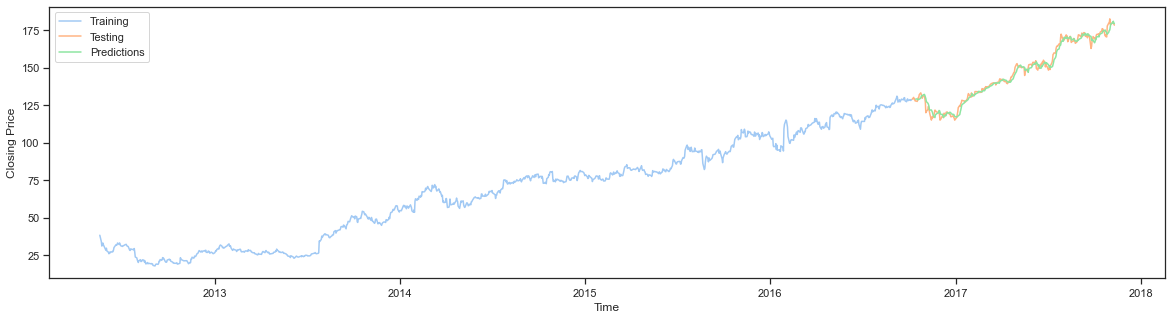

In [50]:
plt.figure(figsize=(20, 5))
i_FB_mark = int(len(stocks['FB']) * 0.8)
plt.plot(stocks['FB']['Date'][:i_FB_mark], 
        stocks['FB']['Close'][:i_FB_mark], label = 'Training')

plt.plot(stocks['FB']['Date'][i_FB_mark:], 
        stocks['FB']['Close'][i_FB_mark:], label = 'Testing')

plt.plot(stocks['FB']['Date'][i_FB_mark+5:], 
        FB_prediction.reshape(-1), label = 'Predictions')

plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [51]:
r2 = r2_score(FB_Y_test, FB_prediction)
rmse = math.sqrt(mean_squared_error(FB_Y_test, FB_prediction))
mape = np.mean(np.abs(FB_prediction - FB_Y_test)/np.abs(FB_Y_test))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'R2 score: {r2}')

RMSE: 2.439560663042889
MAPE: 0.01270308730488271
R2 score: 0.9840957423971667
